## Seed:

In [ ]:
seed = 48 # TODO: replace this with the random seed of your team!

# Note that this should be the general syntax and serves as a guidance,
# errors might appear because of the versions that these packages use

import numpy as np
np.random.seed(seed)
np.random.RandomState(seed)

import random
random.seed(seed)

import torch
torch.manual_seed(seed)
torch.use_deterministic_algorithms(True)

import tensorflow as tf
tf.random.set_seed(seed)

import jax
jax.random.PRNGKey(seed)

Array([ 0, 48], dtype=uint32)

## Loading and preparing the data:

In [ ]:
from google.colab import files
import json
import pandas as pd
from sklearn.model_selection import train_test_split

In [ ]:
! pip install -q kaggle

In [ ]:
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"sasualexandru","key":"fc46af8d5daef6994d84c9dcfb24a948"}'}

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle competitions download -c nitro-language-processing-2

  0% 0.00/2.59M [00:00<?, ?B/s]
100% 2.59M/2.59M [00:00<00:00, 132MB/s]


In [ ]:
! unzip nitro-language-processing-2.zip -d nitro-language-processing-2

Archive:  nitro-language-processing-2.zip
  inflating: nitro-language-processing-2/random_seed_setter.py  
  inflating: nitro-language-processing-2/random_seeds.csv  
  inflating: nitro-language-processing-2/sample_submission.csv  
  inflating: nitro-language-processing-2/test_data.csv  
  inflating: nitro-language-processing-2/train_data.csv  


In [ ]:
train_file_content = pd.read_csv('/content/nitro-language-processing-2/train_data.csv')

In [ ]:
test_file_content = pd.read_csv('/content/nitro-language-processing-2/test_data.csv')

In [ ]:
# train_data, val_data = train_test_split(train_file_content, test_size=0.2, shuffle=True, random_state=seed)
train_data = train_file_content
test_data = test_file_content

# train_frac = 0.5
# train_data = train_data.sample(frac=train_frac, random_state=42)

In [ ]:
final_label_types = ["direct", "descriptive", "reporting", "offensive", "non-offensive"]

texts = list(train_data["Text"])
# texts.pop(2473)
final_labels = list(train_data["Final Labels"])
# final_labels.pop(2473)

print(len(texts))

texts_without_noise = []
final_labels_for_non_noisy_texts = []
for i, text in enumerate(texts):
  if "keyword" not in text:
    texts_without_noise.append(text)
    final_labels_for_non_noisy_texts.append(final_labels[i])

texts = texts_without_noise
final_labels = final_labels_for_non_noisy_texts

print(len(texts))
print(len(final_labels))

test_texts = list(test_data["Text"])

39008
38996
38996


## Preprocessing, tokenizing, BoW:

In [ ]:
def convert_to_lowercase(text):
  text = text.lower()
  
  return text

In [ ]:
import string

def remove_punctuation(text):
  text = text.translate(str.maketrans('', '', string.punctuation))

  return text

In [ ]:
import re

def remove_links_and_references(text):
  text_without_links = re.sub(r'http\S+', '', text)
  text_without_links = re.sub(r'www\S+', '', text_without_links)
  text_without_mentions = re.sub(r'@[a-zA-Z0-9_]+','', text_without_links)
  text_without_hashtags = re.sub(r'#[a-zA-Z0-9_]+','', text_without_mentions)

  return text_without_hashtags

In [ ]:
emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                          "]+", flags=re.UNICODE)

def remove_emojis(text):
  text = emoji_pattern.sub(r'', text)

  return text

In [ ]:
import nltk

nltk.download('stopwords')

from nltk.corpus import stopwords

stop_words_nltk = set(stopwords.words('romanian'))

def remove_stop_words(text):
  preprocessed_text = []

  for word in text:
    if word not in stop_words_nltk:
      preprocessed_text.append(word)

  return preprocessed_text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
from nltk.stem.snowball import SnowballStemmer

stemmer = SnowballStemmer(language='romanian')

def apply_stemming(text):
  text_stemmed = []

  for word in text:
    text_stemmed.append(stemmer.stem(word))

  return text_stemmed

In [ ]:
%%capture
! python -m spacy download ro_core_news_sm

import spacy

nlp = spacy.load("ro_core_news_sm")

def apply_lemmatizing(text):
  preprocessed_text = []

  tokenized_text = nlp(" ".join(text))
  for token in tokenized_text:
    preprocessed_text.append(token.lemma_)
  
  return preprocessed_text

In [ ]:
def preprocess(text):
  text = convert_to_lowercase(text)
  text = remove_punctuation(text)
  text = remove_links_and_references(text)
  text = remove_emojis(text)

  return text

In [ ]:
def tokenize(text):
  text = text.split()
  text = remove_stop_words(text)
  text = apply_stemming(text)
  
  return text

In [ ]:
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split

In [ ]:
labels = []
for final_label in final_labels:
  if final_label == final_label_types[0]:
    labels.append(0)
  elif final_label == final_label_types[1]:
    labels.append(1)
  elif final_label == final_label_types[2]:
    labels.append(2)
  elif final_label == final_label_types[3]:
    labels.append(3)
  elif final_label == final_label_types[4]:
    labels.append(4)

In [ ]:
print(len(texts))
print(len(labels))

38996
38996


In [ ]:
cv_1 = CountVectorizer(
    preprocessor=preprocess,
    tokenizer=tokenize,
    token_pattern=None,
    max_features=1000,  # daca max_features=None, obtinem 30095 features. Dupa ce am inspectat frecventa de aparitie ale tuturor cuvintelor (30095 features), am ales sa selectez doar 1500 din cele mai frecvente cuvinte
    binary=False,
)

cv_1.fit(texts)

# calculeaza reprezentarile textelor (feature vectors)
features_1 = cv_1.transform(texts)
print(features_1.shape)
print(type(features_1))
print(features_1.toarray())  # convertim la numpy array

train_data_1, test_data_1, train_labels_1, test_labels_1 = train_test_split(features_1.toarray(), labels, test_size=0.2, random_state=seed)

# clasa folosita pentru normalizare
scaler_1 = preprocessing.Normalizer(norm='l2') 

scaler_1.fit(train_data_1)

# scalam vectorii de train
train_data_1 = scaler_1.transform(train_data_1)
print(train_data_1)

# scalam vectorii de test
test_data_1 = scaler_1.transform(test_data_1)
print(test_data_1)

(38996, 1000)
<class 'scipy.sparse._csr.csr_matrix'>
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.35355339 0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


In [ ]:
print(sorted(np.sum(features_1.toarray(), axis=0), reverse=True))

[9131, 3823, 2811, 2387, 1951, 1823, 1814, 1720, 1701, 1603, 1502, 1411, 1285, 1262, 1216, 1183, 1147, 1137, 1083, 1080, 996, 995, 994, 979, 951, 912, 909, 906, 897, 889, 870, 851, 844, 828, 818, 809, 756, 741, 739, 736, 728, 718, 705, 673, 671, 668, 660, 656, 641, 588, 586, 586, 584, 575, 573, 564, 560, 556, 553, 548, 541, 531, 528, 524, 523, 520, 517, 517, 515, 510, 509, 505, 501, 497, 495, 488, 486, 482, 481, 481, 474, 474, 473, 471, 469, 462, 459, 453, 453, 447, 444, 443, 442, 433, 433, 432, 432, 416, 414, 414, 411, 408, 407, 398, 397, 397, 395, 395, 392, 390, 389, 387, 383, 383, 378, 374, 374, 370, 368, 367, 367, 365, 365, 359, 359, 359, 357, 353, 351, 350, 349, 346, 345, 341, 336, 336, 333, 332, 330, 330, 328, 325, 323, 320, 318, 318, 316, 315, 315, 314, 313, 312, 309, 309, 309, 308, 307, 307, 303, 303, 302, 300, 299, 296, 295, 293, 293, 292, 291, 291, 289, 289, 286, 286, 285, 284, 284, 284, 284, 282, 282, 280, 277, 276, 276, 276, 274, 273, 272, 271, 271, 269, 267, 267, 263, 263,

In [ ]:
print(len(np.sum(features_1.toarray(), axis=0)))

1000


In [ ]:
test_data_true = cv_1.transform(test_texts)
print(test_data_true.shape)
print(type(test_data_true))
print(test_data_true.toarray())  # convertim la numpy array

test_data_true = scaler_1.transform(test_data_true)

(3130, 1000)
<class 'scipy.sparse._csr.csr_matrix'>
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [ ]:
cv_1 = TfidfVectorizer(
    preprocessor=preprocess_1_2_3,
    tokenizer=tokenize_1,
    token_pattern=None,
    max_features=1000,  # daca max_features=None, obtinem 30095 features. Dupa ce am inspectat frecventa de aparitie ale tuturor cuvintelor (30095 features), am ales sa selectez doar 1500 din cele mai frecvente cuvinte
    binary=False,
)

cv_1.fit(texts)

# calculeaza reprezentarile textelor (feature vectors)
features_1 = cv_1.transform(texts)
print(features_1.shape)
print(type(features_1))
print(features_1.toarray())  # convertim la numpy array

train_data_1, test_data_1, train_labels_1, test_labels_1 = train_test_split(features_1.toarray(), labels, test_size=0.2, random_state=seed)

print(train_data_1)
print(test_data_1)

(39008, 1000)
<class 'scipy.sparse._csr.csr_matrix'>
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


## Training, validation, metrics:

In [ ]:
from sklearn.naive_bayes import GaussianNB

In [ ]:
clf_1 = GaussianNB()

clf_1.fit(train_data_1, train_labels_1)

GaussianNB()

In [ ]:
from sklearn import metrics

In [ ]:
predicted_labels_1 = clf_1.predict(test_data_1)

In [ ]:
print("Accuracy:", metrics.accuracy_score(test_labels_1, predicted_labels_1))
print()
print("Precision (micro):", metrics.precision_score(test_labels_1, predicted_labels_1, average="micro"))
print("Precision (macro):", metrics.precision_score(test_labels_1, predicted_labels_1, average="macro"))
print("Precision (weighted):", metrics.precision_score(test_labels_1, predicted_labels_1, average="weighted"))
print()
print("Recall (micro):", metrics.recall_score(test_labels_1, predicted_labels_1, average="micro"))
print("Recall (macro):", metrics.recall_score(test_labels_1, predicted_labels_1, average="macro"))
print("Recall (weighted):", metrics.recall_score(test_labels_1, predicted_labels_1, average="weighted"))
print()
print("F1 (micro):", metrics.f1_score(test_labels_1, predicted_labels_1, average="micro"))
print("F1 (macro):", metrics.f1_score(test_labels_1, predicted_labels_1, average="macro"))
print("F1 (weighted):", metrics.f1_score(test_labels_1, predicted_labels_1, average="weighted"))

Accuracy: 0.19256410256410256

Precision (micro): 0.19256410256410256
Precision (macro): 0.25855570956801566
Precision (weighted): 0.7555126507229644

Recall (micro): 0.19256410256410256
Recall (macro): 0.2659079072571127
Recall (weighted): 0.19256410256410256

F1 (micro): 0.19256410256410256
F1 (macro): 0.15052841310412046
F1 (weighted): 0.2650636849918749


In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [ ]:
clf_dec_tree = DecisionTreeClassifier(max_depth=5, min_samples_split=5)

clf_dec_tree.fit(train_data_1, train_labels_1)

predicted_labels_dec_tree = clf_dec_tree.predict(test_data_1)

In [ ]:
print(predicted_labels_dec_tree[:1000])

[4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 3 3 4 4 4 4 4 4 4 4 4 3 4 4 4 4 4 4 4 1 4
 4 4 4 4 4 4 4 4 4 4 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 3 4 4 4 4 4 4 4 4 4 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 0 0 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 0 4 4 4 4 4 4 4 4 4 4 4
 4 3 4 4 4 4 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 0 4 4 4 4 4 3 4 1 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 1 4 4 4 4 4 4 4 4 4 4 4 4 4 4 3 4 1 4 4 4 4 4 4 4 4 4 4 4 1
 4 4 4 4 4 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 3 4 4 3 4 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 3 4 4 4 4 4 4 4 1 4
 4 4 4 4 4 4 4 4 4 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 

In [ ]:
print("Accuracy:")
print(f"Decision Tree {metrics.accuracy_score(test_labels_1, predicted_labels_dec_tree)} | GaussianNB {metrics.accuracy_score(test_labels_1, predicted_labels_1)}")
print()
print("Precision (micro):")
print(f"Decision Tree {metrics.precision_score(test_labels_1, predicted_labels_dec_tree, average='micro')} | GaussianNB {metrics.precision_score(test_labels_1, predicted_labels_1, average='micro')}")
print("Precision (macro):")
print(f"Decision Tree {metrics.precision_score(test_labels_1, predicted_labels_dec_tree, average='macro')} | GaussianNB {metrics.precision_score(test_labels_1, predicted_labels_1, average='macro')}")
print("Precision (weighted):")
print(f"Decision Tree {metrics.precision_score(test_labels_1, predicted_labels_dec_tree, average='weighted')} | GaussianNB {metrics.precision_score(test_labels_1, predicted_labels_1, average='weighted')}")
print()
print("Recall (micro):")
print(f"Decision Tree {metrics.recall_score(test_labels_1, predicted_labels_dec_tree, average='micro')} | GaussianNB {metrics.recall_score(test_labels_1, predicted_labels_1, average='micro')}")
print("Recall (macro):")
print(f"Decision Tree {metrics.recall_score(test_labels_1, predicted_labels_dec_tree, average='macro')} | GaussianNB {metrics.recall_score(test_labels_1, predicted_labels_1, average='macro')}")
print("Recall (weighted):")
print(f"Decision Tree {metrics.recall_score(test_labels_1, predicted_labels_dec_tree, average='weighted')} | GaussianNB {metrics.recall_score(test_labels_1, predicted_labels_1, average='weighted')}")
print()
print("F1 (micro):")
print(f"Decision Tree {metrics.f1_score(test_labels_1, predicted_labels_dec_tree, average='micro')} | GaussianNB {metrics.f1_score(test_labels_1, predicted_labels_1, average='micro')}")
print("F1 (macro):")
print(f"Decision Tree {metrics.f1_score(test_labels_1, predicted_labels_dec_tree, average='macro')} | GaussianNB {metrics.f1_score(test_labels_1, predicted_labels_1, average='macro')}")
print("F1 (weighted):")
print(f"Decision Tree {metrics.f1_score(test_labels_1, predicted_labels_dec_tree, average='weighted')} | GaussianNB {metrics.f1_score(test_labels_1, predicted_labels_1, average='weighted')}")

Accuracy:
Decision Tree 0.8273519610356319 | GaussianNB 0.19072032812099463

Precision (micro):
Decision Tree 0.8273519610356319 | GaussianNB 0.19072032812099463
Precision (macro):
Decision Tree 0.5203163974048631 | GaussianNB 0.2600488064775045
Precision (weighted):
Decision Tree 0.7964132242548033 | GaussianNB 0.763750805998103

Recall (micro):
Decision Tree 0.8273519610356319 | GaussianNB 0.19072032812099463
Recall (macro):
Decision Tree 0.3296079011783342 | GaussianNB 0.2881195131841879
Recall (weighted):
Decision Tree 0.8273519610356319 | GaussianNB 0.19072032812099463

F1 (micro):
Decision Tree 0.8273519610356319 | GaussianNB 0.19072032812099465
F1 (macro):
Decision Tree 0.37132931637644234 | GaussianNB 0.15202301076422484
F1 (weighted):
Decision Tree 0.7911931040901998 | GaussianNB 0.25718501277475475


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
predicted_labels_dec_tree_test_true = clf_dec_tree.predict(test_data_true)

In [ ]:
print(predicted_labels_dec_tree_test_true[:1000])

[4 4 4 1 4 1 4 4 3 4 4 4 4 4 1 4 4 4 4 1 4 4 4 1 4 4 4 4 1 4 4 4 1 4 4 4 4
 1 4 1 4 4 4 4 4 4 1 4 4 4 4 1 4 4 4 4 4 4 4 4 1 1 4 1 4 1 4 1 4 4 4 4 4 4
 4 4 4 1 4 3 4 1 4 4 1 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 1 1 1 4 4 4 4 1 1 1
 4 4 4 4 4 4 4 4 1 4 1 1 4 4 4 4 4 1 1 4 4 4 1 4 4 1 4 4 4 4 4 4 4 4 4 1 4
 4 4 4 4 4 1 4 4 4 1 4 4 1 4 4 4 4 4 4 1 4 4 1 1 4 4 1 4 4 1 4 4 4 3 4 3 1
 1 4 4 4 4 1 4 4 4 4 4 4 4 1 4 4 4 4 4 4 4 1 1 1 4 4 4 1 4 1 4 4 4 1 1 4 4
 4 4 1 4 4 4 4 4 4 4 4 4 4 4 4 1 4 4 4 1 4 4 4 4 4 4 1 4 1 4 4 4 4 1 4 4 4
 4 4 4 4 4 1 4 4 4 4 4 4 4 4 4 4 4 1 4 4 4 4 4 1 4 4 4 4 4 1 4 4 4 1 4 4 4
 3 4 4 4 4 4 4 4 1 4 4 4 4 4 4 4 1 4 4 4 4 1 1 1 4 1 4 4 4 1 1 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 1 4 4 4 4 4 1 4 1 1 4 4 1 4 4 4 4 4 4 4 4 4 4 3 4 4 4 4 3
 4 4 4 1 4 4 1 4 4 4 1 4 4 4 1 4 4 4 1 4 4 4 1 4 4 4 4 4 4 4 1 4 4 4 4 1 1
 1 4 4 1 1 1 4 4 4 1 4 1 4 1 4 4 4 4 4 4 4 1 4 4 1 4 4 4 4 4 4 4 4 4 1 4 4
 4 1 4 4 4 4 1 4 1 1 4 4 1 4 1 4 4 1 4 4 1 4 4 1 1 1 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 1 4 4 4 

In [ ]:
print(list(predicted_labels_dec_tree_test_true))

[4, 4, 4, 1, 4, 1, 4, 4, 3, 4, 4, 4, 4, 4, 1, 4, 4, 4, 4, 1, 4, 4, 4, 1, 4, 4, 4, 4, 1, 4, 4, 4, 1, 4, 4, 4, 4, 1, 4, 1, 4, 4, 4, 4, 4, 4, 1, 4, 4, 4, 4, 1, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 4, 1, 4, 1, 4, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 4, 3, 4, 1, 4, 4, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 1, 4, 4, 4, 4, 1, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 1, 4, 1, 1, 4, 4, 4, 4, 4, 1, 1, 4, 4, 4, 1, 4, 4, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 4, 4, 4, 4, 4, 4, 1, 4, 4, 4, 1, 4, 4, 1, 4, 4, 4, 4, 4, 4, 1, 4, 4, 1, 1, 4, 4, 1, 4, 4, 1, 4, 4, 4, 3, 4, 3, 1, 1, 4, 4, 4, 4, 1, 4, 4, 4, 4, 4, 4, 4, 1, 4, 4, 4, 4, 4, 4, 4, 1, 1, 1, 4, 4, 4, 1, 4, 1, 4, 4, 4, 1, 1, 4, 4, 4, 4, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 4, 4, 4, 1, 4, 4, 4, 4, 4, 4, 1, 4, 1, 4, 4, 4, 4, 1, 4, 4, 4, 4, 4, 4, 4, 4, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 4, 4, 4, 4, 4, 1, 4, 4, 4, 4, 4, 1, 4, 4, 4, 1, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 1, 4, 4, 4, 4, 4, 4, 4, 1, 4, 4, 4, 4, 1, 1, 1, 4, 1, 4, 4, 4, 1, 1, 4, 4, 4, 4, 4, 4, 

In [ ]:
print(predicted_labels_mlp_test_true_strings[:1000])

['non-offensive', 'non-offensive', 'non-offensive', 'descriptive', 'non-offensive', 'non-offensive', 'non-offensive', 'non-offensive', 'offensive', 'non-offensive', 'non-offensive', 'non-offensive', 'non-offensive', 'non-offensive', 'descriptive', 'non-offensive', 'non-offensive', 'non-offensive', 'non-offensive', 'descriptive', 'non-offensive', 'non-offensive', 'non-offensive', 'descriptive', 'non-offensive', 'non-offensive', 'non-offensive', 'non-offensive', 'non-offensive', 'non-offensive', 'non-offensive', 'non-offensive', 'non-offensive', 'non-offensive', 'non-offensive', 'non-offensive', 'descriptive', 'descriptive', 'non-offensive', 'descriptive', 'non-offensive', 'non-offensive', 'non-offensive', 'non-offensive', 'non-offensive', 'non-offensive', 'descriptive', 'non-offensive', 'non-offensive', 'descriptive', 'non-offensive', 'descriptive', 'non-offensive', 'descriptive', 'non-offensive', 'non-offensive', 'non-offensive', 'non-offensive', 'non-offensive', 'non-offensive', 'desc

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=3)

knn.fit(train_data_1, train_labels_1)

KNeighborsClassifier(n_neighbors=3)

In [ ]:
predicted_labels_knn = knn.predict(test_data_1)

In [ ]:
predicted_labels_knn_test_true = knn.predict(test_data_true)

In [ ]:
print(predicted_labels_knn_test_true[:1000])

[4 4 4 1 4 4 4 4 3 0 4 4 4 4 1 4 4 4 4 4 4 4 4 1 4 4 4 4 4 4 4 4 4 4 4 4 1
 1 4 4 4 4 4 4 4 4 1 4 4 4 4 4 4 0 4 4 4 4 4 4 1 1 4 4 4 4 4 1 4 4 4 4 4 4
 4 4 4 1 4 3 4 4 4 4 1 4 4 4 4 4 4 4 4 4 4 4 4 4 4 3 4 1 4 4 4 0 4 4 4 4 1
 4 4 4 4 4 4 4 4 1 4 1 4 4 4 4 4 4 1 1 1 4 4 1 4 4 1 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 1 4 4 4 4 4 3 4 3 4 1 4 4 4 4 4 4 1 4 4 1 0 4 4 3 4 3 4
 1 1 4 4 4 0 4 4 4 3 4 4 4 1 4 4 4 4 1 4 4 1 4 4 4 0 4 1 0 0 1 1 4 4 1 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 1 4 4 0 4 4 0 4 1 0 4 4 4 0 4 4 4
 4 0 4 1 4 4 4 4 4 4 4 4 4 4 4 4 4 1 4 0 4 4 4 4 4 4 4 3 4 1 4 4 4 1 4 4 4
 0 0 4 4 4 4 4 4 4 4 0 4 4 4 4 4 4 4 4 4 4 4 1 1 4 4 4 4 4 1 4 4 4 4 0 0 4
 4 4 4 4 4 4 4 4 1 4 4 4 4 4 4 4 1 1 4 4 4 4 4 4 4 4 4 4 4 4 4 3 4 4 4 4 3
 0 4 4 4 4 4 1 4 4 4 4 4 4 4 4 4 4 4 1 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 1 4
 1 4 4 1 4 4 1 4 4 1 4 4 4 1 4 4 4 4 4 4 4 1 4 4 4 3 0 4 4 4 0 4 4 4 1 4 4
 4 4 4 4 4 3 4 4 4 4 4 4 1 4 4 4 0 4 4 4 1 4 4 4 1 1 4 4 4 4 4 0 4 0 4 4 4
 4 4 4 4 4 4 4 4 1 4 4 4 

In [ ]:
print(list(predicted_labels_knn_test_true))

[4, 4, 4, 1, 4, 4, 4, 4, 3, 0, 4, 4, 4, 4, 1, 4, 4, 4, 4, 4, 4, 4, 4, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 1, 4, 4, 4, 4, 4, 4, 0, 4, 4, 4, 4, 4, 4, 1, 1, 4, 4, 4, 4, 4, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 4, 3, 4, 4, 4, 4, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 1, 4, 4, 4, 0, 4, 4, 4, 4, 1, 4, 4, 4, 4, 4, 4, 4, 4, 1, 4, 1, 4, 4, 4, 4, 4, 4, 1, 1, 1, 4, 4, 1, 4, 4, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 4, 4, 4, 4, 4, 3, 4, 3, 4, 1, 4, 4, 4, 4, 4, 4, 1, 4, 4, 1, 0, 4, 4, 3, 4, 3, 4, 1, 1, 4, 4, 4, 0, 4, 4, 4, 3, 4, 4, 4, 1, 4, 4, 4, 4, 1, 4, 4, 1, 4, 4, 4, 0, 4, 1, 0, 0, 1, 1, 4, 4, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 4, 4, 0, 4, 4, 0, 4, 1, 0, 4, 4, 4, 0, 4, 4, 4, 4, 0, 4, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 4, 0, 4, 4, 4, 4, 4, 4, 4, 3, 4, 1, 4, 4, 4, 1, 4, 4, 4, 0, 0, 4, 4, 4, 4, 4, 4, 4, 4, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 4, 4, 4, 4, 4, 1, 4, 4, 4, 4, 0, 0, 4, 

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

mlp = MLPClassifier(random_state=seed, activation="relu", solver="adam", max_iter=300, early_stopping=True).fit(train_data_1, train_labels_1)

In [ ]:
predicted_labels_mlp = mlp.predict(test_data_1)

In [ ]:
predicted_labels_mlp_test_true = mlp.predict(test_data_true)

In [ ]:
print(predicted_labels_mlp_test_true[:1000])

[4 4 4 1 4 4 4 4 3 4 4 4 4 4 1 4 4 4 4 1 4 4 4 1 4 4 4 4 4 4 4 4 4 4 4 4 1
 1 4 1 4 4 4 4 4 4 1 4 4 1 4 1 4 1 4 4 4 4 4 4 1 1 4 1 4 1 4 1 4 4 4 4 4 4
 1 4 4 1 4 3 4 4 4 4 1 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 1 1 4 3 1 4 4 4 1 1
 4 4 1 4 1 4 4 4 1 4 1 1 1 4 1 4 4 4 1 1 4 4 1 4 4 1 4 4 4 1 4 4 4 4 4 1 4
 4 4 4 4 4 4 4 1 4 1 4 4 1 4 4 4 4 4 4 1 4 4 4 1 4 4 1 4 4 1 4 4 4 3 4 3 1
 1 1 4 4 4 1 1 4 4 1 4 4 4 1 4 4 4 4 1 4 4 1 1 4 4 1 4 1 0 1 1 4 4 1 1 4 1
 4 4 1 4 4 4 4 4 4 4 4 4 4 4 4 1 4 4 4 1 1 4 4 0 4 4 4 4 1 1 4 4 4 1 4 4 4
 4 1 4 4 4 1 4 4 4 4 4 4 4 4 4 4 4 1 4 4 4 4 4 4 4 4 4 4 4 1 4 4 4 1 4 3 4
 3 3 4 4 4 4 4 4 1 4 1 4 4 4 4 4 1 4 4 4 4 1 1 1 4 4 4 4 4 1 1 4 4 4 4 4 1
 4 4 4 4 4 4 4 4 1 4 4 4 4 4 1 4 1 1 4 4 1 4 4 4 4 4 3 4 4 4 4 3 4 4 4 4 3
 1 4 4 1 3 4 1 4 4 4 1 4 4 4 4 4 4 4 1 4 0 4 1 4 4 4 4 4 1 4 1 4 4 4 4 1 1
 1 4 4 1 1 4 1 4 4 1 4 1 4 1 4 4 4 4 4 4 4 1 4 4 4 4 4 4 4 4 4 4 4 4 1 4 1
 4 1 4 4 4 4 1 4 1 4 4 4 1 4 4 4 4 1 3 4 1 4 4 1 4 1 4 3 3 3 4 3 4 4 4 4 4
 3 4 3 4 4 4 4 3 1 4 4 4 

In [ ]:
print(list(predicted_labels_mlp_test_true))

[4, 4, 4, 1, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 1, 4, 4, 4, 4, 1, 4, 4, 4, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 4, 1, 4, 4, 4, 4, 4, 4, 1, 4, 4, 1, 4, 1, 4, 1, 4, 4, 4, 4, 4, 4, 1, 1, 4, 1, 4, 1, 4, 1, 4, 4, 4, 4, 4, 4, 1, 4, 4, 1, 4, 3, 4, 4, 4, 4, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 4, 3, 1, 4, 4, 4, 1, 1, 4, 4, 1, 4, 1, 4, 4, 4, 1, 4, 1, 1, 1, 4, 1, 4, 4, 4, 1, 1, 4, 4, 1, 4, 4, 1, 4, 4, 4, 1, 4, 4, 4, 4, 4, 1, 4, 4, 4, 4, 4, 4, 4, 4, 1, 4, 1, 4, 4, 1, 4, 4, 4, 4, 4, 4, 1, 4, 4, 4, 1, 4, 4, 1, 4, 4, 1, 4, 4, 4, 3, 4, 3, 1, 1, 1, 4, 4, 4, 1, 1, 4, 4, 1, 4, 4, 4, 1, 4, 4, 4, 4, 1, 4, 4, 1, 1, 4, 4, 1, 4, 1, 0, 1, 1, 4, 4, 1, 1, 4, 1, 4, 4, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 4, 4, 4, 1, 1, 4, 4, 0, 4, 4, 4, 4, 1, 1, 4, 4, 4, 1, 4, 4, 4, 4, 1, 4, 4, 4, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 4, 4, 4, 1, 4, 3, 4, 3, 3, 4, 4, 4, 4, 4, 4, 1, 4, 1, 4, 4, 4, 4, 4, 1, 4, 4, 4, 4, 1, 1, 1, 4, 4, 4, 4, 4, 1, 1, 4, 4, 4, 4, 4, 1, 

In [ ]:
final_label_types = ["direct", "descriptive", "reporting", "offensive", "non-offensive"]

pred_labels = []
for test_label in predicted_labels_mlp_test_true:
  if test_label == 0:
    pred_labels.append("direct")
  elif test_label == 1:
    pred_labels.append("descriptive")
  elif test_label == 2:
    pred_labels.append("reporting")
  elif test_label == 3:
    pred_labels.append("offensive")
  elif test_label == 4:
    pred_labels.append("non-offensive")

In [ ]:
# Populam fisierul aferent predictiilor
fout = open("submission.csv", "w")
fout.write("Id,Label\n")
# fin = open("data/test.txt", "r")
# fin.readline()
# index = 0
# for test_img in fin:
#     fout.write(test_img.rstrip() + "," + str(int(predicted_labels[index])) + "\n")
#     index += 1
# fout.close()
# fin.close()

for i in range(len(pred_labels)):
  fout.write(str(i) + ',' + pred_labels[i] + "\n")

fout.close()

In [ ]:
import seaborn as sns

In [ ]:
print(metrics.classification_report(train_labels_1, test_labels_1))

              precision    recall  f1-score   support

           0       0.94      0.69      0.80      7138
           1       0.67      0.61      0.64      3575
           2       0.73      0.32      0.44      3488
           3       0.36      0.87      0.51      1968
           4       0.41      0.71      0.52      1956

    accuracy                           0.62     18125
   macro avg       0.62      0.64      0.58     18125
weighted avg       0.73      0.62      0.64     18125



In [ ]:
cm = metrics.confusion_matrix(test_labels_1, predicted_labels_1)
print(cm)

[[4909  574  282  893  480]
 [  56 2196   40 1049  234]
 [ 180  311 1107  716 1174]
 [  30  108   24 1713   93]
 [  25  100   54  391 1386]]


<Axes: >

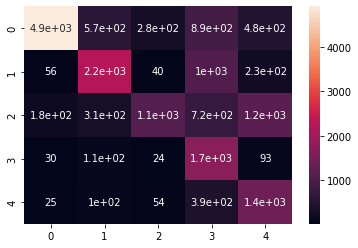

In [ ]:
sns.heatmap(cm, annot=True)